In [1]:
import keras.utils
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, Dense, Conv1D, GlobalMaxPooling1D
from keras.preprocessing.text import Tokenizer
from keras.losses import binary_crossentropy
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Bidirectional, LSTM


In [2]:
label_encoder = LabelEncoder()
# train_df = 'synthetic_train.csv'
# val_df = 'synthetic_train.csv'
# #load data and specify the text column and the sentiment column
# #Train data
# train_data = pd.read_csv(train_df)
# X_train = train_data['sentence'].values  #text column
# y_train = train_data['sentiment'].values  #sentiment column
# #Validation data
# val_data = pd.read_csv(val_df)
# X_val = train_data['sentence'].values  #text column
# y_val = train_data['sentiment'].values  #sentiment column
#
# #encoded the label to a numerical tag for model to understand
# y_train = label_encoder.fit_transform(y_train)
# y_val = label_encoder.transform(y_val)
data = pd.read_csv('TV.csv')

# Split the data into training and validation sets
X = data['Nhận xét đánh giá'].values
y = data['Cảm xúc'].values
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode the labels
y_train = label_encoder.fit_transform(y_train)
y_val = label_encoder.transform(y_val)


In [7]:
max_words = 5000  # Maximum number of words to consider
max_len = 1000  # Maximum length of a sequence
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_val = np.reshape(X_val, (X_val.shape[0], X_val.shape[1], 1))

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_train_seq = keras.utils.pad_sequences(X_train_seq, maxlen=max_len)
X_val_seq = keras.utils.pad_sequences(X_val_seq, maxlen=max_len)

IndexError: tuple index out of range

In [5]:
embedding_dim = 100  # Dimensionality of word embeddings
num_filters = 128  # Number of filters in the convolutional layer
kernel_size = 3
num_classes = len(label_encoder.classes_)  # Number of output classes
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_len))
model.add(Conv1D(num_filters, kernel_size, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(LSTM(64, return_sequences=True))
model.add(Dense(num_classes, activation='softmax'))


model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])




ValueError: Input 0 of layer "lstm_1" is incompatible with the layer: expected ndim=3, found ndim=2. Full shape received: (None, 128)

In [12]:
batch_size = 32
epochs = 10

model.fit(X_train_seq, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val_seq, y_val))


Epoch 1/10
415/415 [==============================] - 57s 135ms/step - loss: 0.9164 - accuracy: 0.6365 - val_loss: 0.7943 - val_accuracy: 0.6904
Epoch 2/10
415/415 [==============================] - 57s 138ms/step - loss: 0.7063 - accuracy: 0.7342 - val_loss: 0.7517 - val_accuracy: 0.7166
Epoch 3/10
415/415 [==============================] - 54s 131ms/step - loss: 0.6303 - accuracy: 0.7657 - val_loss: 0.7551 - val_accuracy: 0.7075
Epoch 4/10
415/415 [==============================] - 58s 141ms/step - loss: 0.5743 - accuracy: 0.7900 - val_loss: 0.7693 - val_accuracy: 0.7163
Epoch 5/10
415/415 [==============================] - 57s 137ms/step - loss: 0.5234 - accuracy: 0.8135 - val_loss: 0.8013 - val_accuracy: 0.7096
Epoch 6/10
415/415 [==============================] - 57s 137ms/step - loss: 0.4813 - accuracy: 0.8306 - val_loss: 0.8236 - val_accuracy: 0.7063
Epoch 7/10
415/415 [==============================] - 56s 135ms/step - loss: 0.4482 - accuracy: 0.8441 - val_loss: 0.8503 - val_ac

In [7]:
loss, accuracy = model.evaluate(X_val_seq, y_val)
print(f"Validation loss: {loss}")
print(f"Validation accuracy: {accuracy}")

104/104 [==============================] - 1s 5ms/step - loss: 0.9287 - accuracy: 0.6967
Validation loss: 0.9286503195762634
Validation accuracy: 0.6966867446899414


255/255 [==============================] - 1s 4ms/step


KeyError: 2

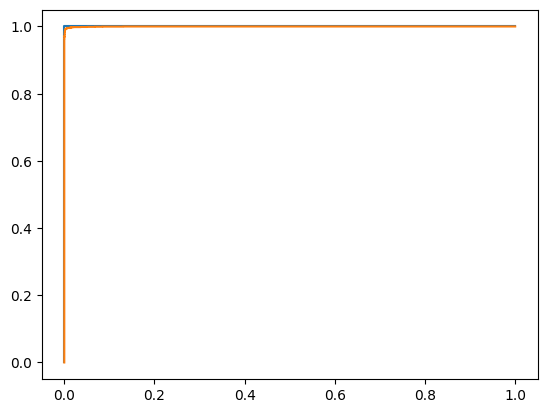

In [8]:
X_val_seq = keras.utils.pad_sequences(X_val_seq, maxlen=max_len)  # Pad validation sequences
y_pred_probs = model.predict(X_val_seq)

# Extract probabilities for each class
class_probs = y_pred_probs[:, 1:]  # Exclude probabilities for the first class (irrelevant)

# Calculate ROC curve and AUC for each class
fpr = dict()
tpr = dict()
auc = dict()
for i in range(num_classes - 1):
    fpr[i], tpr[i], _ = roc_curve((y_val == i + 1).astype(int), class_probs[:, i])
    auc[i] = roc_auc_score((y_val == i + 1).astype(int), class_probs[:, i])

# Plot ROC curves for each class
plt.figure()
plt.plot(fpr[0], tpr[0], label='Positive')
plt.plot(fpr[1], tpr[1], label='Negative')
plt.plot(fpr[2], tpr[2], label='Neutral')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

# Print AUC for each class
print(f"AUC (Positive): {auc[0]}")
print(f"AUC (Negative): {auc[1]}")
print(f"AUC (Neutral): {auc[2]}")

In [8]:
y_pred = model.predict(X_val_seq)
# Convert numerical labels to original labels
y_pred_labels = np.argmax(y_pred, axis=1)
y_pred_labels = label_encoder.inverse_transform(y_pred_labels)

# Convert true labels to original labels
y_val_labels = label_encoder.inverse_transform(y_val)

# Generate classification report
report = classification_report(y_val_labels, y_pred_labels)
print(report)

104/104 [==============================] - 1s 4ms/step
                 precision    recall  f1-score   support

    bình thường       0.64      0.54      0.58       991
không liên quan       0.00      0.00      0.00        40
         rất tệ       0.00      0.00      0.00        10
        rất tốt       0.10      0.01      0.02        93
             tệ       0.88      0.85      0.86       746
            tốt       0.65      0.79      0.72      1440

       accuracy                           0.70      3320
      macro avg       0.38      0.37      0.36      3320
   weighted avg       0.67      0.70      0.68      3320



D:\CODE\Python\SentimentalAnalysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\CODE\Python\SentimentalAnalysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
D:\CODE\Python\SentimentalAnalysis\venv\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
